# K-means Clustering

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

%matplotlib inline

## Utils

In [2]:
def load_data(path: str = "data/ex7_X.npy"):
    X = np.load(path)
    return X

In [3]:
def draw_line(p1, p2, style="-k", linewidth=1):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], style, linewidth=linewidth)

In [4]:
def plot_data_points(X, idx):
    # plots data points in X, coloring them so that those with the same
    # index assignments in idx have the same color
    plt.scatter(X[:, 0], X[:, 1], c=idx)

In [5]:
def plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i):
    # Plot the examples
    plot_data_points(X, idx)
    
    # Plot the centroids as black 'x's
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='k', linewidths=3)
    
    # Plot history of the centroids with lines
    for j in range(centroids.shape[0]):
        draw_line(centroids[j, :], previous_centroids[j, :])
    
    plt.title("Iteration number %d" %i)

In [6]:
def plot_progress_kMeans_3d(X, centroids, previous_centroids, idx, K, i, ax):
    # Plot the examples
    markers = ["." , "," , "o" , "v" , "^" , "<", ">", "8", "s", "p", "P", "*", "h", "H", "X", "D", "d"]

    linearColorSegment = mpl.colormaps["gnuplot"]
    color_list = [mcolors.rgb2hex(linearColorSegment(i)) for i in range(linearColorSegment.N)]
    for k in range(K):
        ax.scatter(
            X[idx == k, 0], X[idx == k, 1], X[idx == k, 2],
            marker=markers[k % len(markers)],
            facecolors=X[idx == k],
            zorder=-1,
            linewidth=0.1,
            # edgecolors='color_list[int((k * len(color_list)) / K)]' # to give a unique color to each class
            edgecolors='k'
        )
    
    # Plot the centroids as black 'x's
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', c='k', linewidths=3, zorder=200)
    
    # Plot history of the centroids with lines
    for j in range(centroids.shape[0]):
        p1 = centroids[j, :]
        p2 = previous_centroids[j, :]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], linewidth=2, c='k', zorder=200)
    
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    plt.title("Iteration number %d" %i)

In [7]:
# Load an example dataset that we will be using
X = load_data()

In [8]:
print("First five elements of X are:\n", X[:5]) 
print('The shape of X is:', X.shape)

First five elements of X are:
 [[1.84207953 4.6075716 ]
 [5.65858312 4.79996405]
 [6.35257892 3.2908545 ]
 [2.90401653 4.61220411]
 [3.23197916 4.93989405]]
The shape of X is: (300, 2)


## Finding closest centroids
In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example 𝑥(𝑖) to its closest centroid, given the current positions of centroids.

In [9]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): k centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """
    K = centroids.shape[0]
    
    # matrix of the closest centroid for each x(i)
    idx = np.zeros(X.shape[0], dtype=int)

    # distance of each point the each centroids => ||x(i) - µj||² where µj is the position of the j'th centroid
    a = np.linalg.norm(X[:, None] - centroids, axis=2)
    # Remains the min distance, in order to get the closest centroid
    idx = np.argmin(a, axis=1)
    
    return idx

In [10]:
# Load an example dataset that we will be using
X = load_data()

In [11]:
# print("First five elements of X are:\n", X[:5]) 
print('The shape of X is:', X.shape)

The shape of X is: (300, 2)


In [12]:
# Select an initial set of centroids (3 Centroids)
initial_centroids = np.array([[3,3], [6,2], [8,5]])

# Find closest centroids using initial_centroids
idx = find_closest_centroids(X, initial_centroids)

# Print closest centroids for the first three elements
print("First three elements in idx are:", idx[:3])

First three elements in idx are: [0 2 1]


In [13]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    m, n = X.shape
    centroids = np.zeros((K, n))
    
    # µk = 1/|𝐶𝑘| * ∑𝑥(𝑖)
    # where:
    # - µk is the new centroid k
    # - Ck is the set of examples that are assigned to centroid 𝑘
    # - |𝐶𝑘| is the number of examples in the set 𝐶𝑘
    for k in range(K):   
        points = X[idx == k]
        centroids[k] = np.mean(points, axis = 0)
    
    return centroids

In [14]:
K = 3
centroids = compute_centroids(X, idx, K)

print("The centroids are:\n", centroids)

The centroids are:
 [[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


## Testing on a sample dataset

In [15]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False, dim=2):
    """
    In the data matrix X, each row of X is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    
    if dim == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(projection='3d')
    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Plot progress
        if plot_progress:
            if dim != 3:
                plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            else:
                plot_progress_kMeans_3d(X, centroids, previous_centroids, idx, K, i, ax)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show() 
    return centroids, idx

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


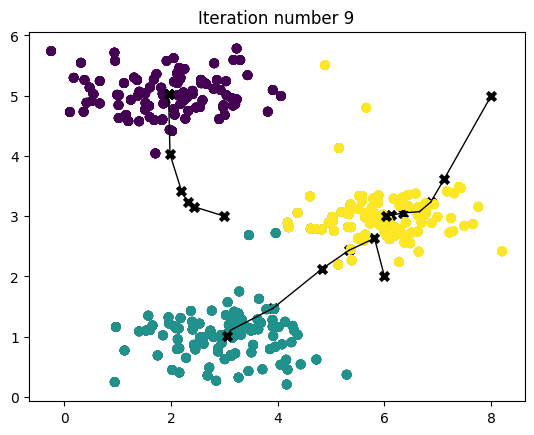

In [16]:
# Load an example dataset
X = load_data()

# Set initial centroids
initial_centroids = np.array([[3,3],[6,2],[8,5]])
K = 3

# Number of iterations
max_iters = 10

centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

## Random initialization

In [17]:
def kMeans_init_centroids(X, K):
    """
    This function initializes K centroids that are to be 
    used in K-Means on the dataset X
    
    Args:
        X (ndarray): Data points 
        K (int):     number of centroids/clusters
    
    Returns:
        centroids (ndarray): Initialized centroids
    """
    
    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])
    
    # Take the first K examples as centroids
    centroids = X[randidx[:K]]
    
    return centroids

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


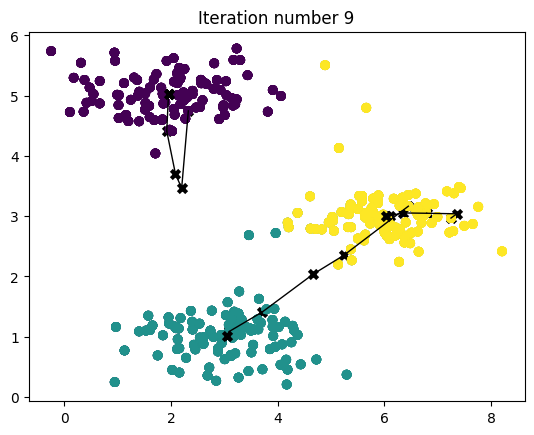

In [18]:
# Load an example dataset
X = load_data()

# Set initial centroids
initial_centroids = kMeans_init_centroids(X, 3)
K = 3

# Number of iterations
max_iters = 10

centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

## Image compression with K-means
### Load image

First, we will use matplotlib to read in the original image, as shown below.

In [19]:
# Load an image of a bird
original_img = plt.imread('data/Heydar_Aliyev_Center_Baku.jpg')

### Visualize image
We can visualize the image that was just loaded using the code below.

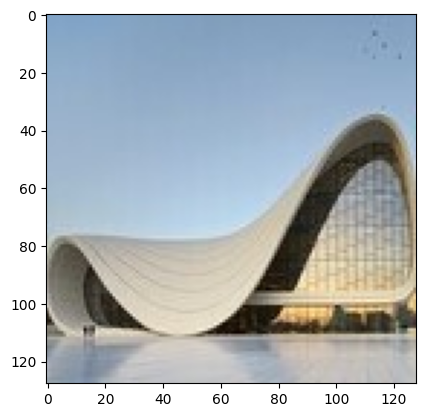

In [20]:
# Visualizing the image
plt.imshow(original_img)

### Check the dimension of the variable
As always, we will print out the shape of our variable.
We have an image of 128x128 pixel with 3 color (rgb)

In [21]:
print("Shape of original_img is:", original_img.shape)

Shape of original_img is: (128, 128, 3)


### Processing data
We have to transform the three-dimensional matrix into a two-dimensional matrix

In [22]:
# Divide by 255 so that all values are in the range 0 - 1
original_img = original_img / 255

# Reshape the image into an m x 3 matrix where m = number of pixels
# (in this case m = 128 x 128 = 16384)
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X_img that we will use K-Means on.

X_img = np.reshape(original_img, (original_img.shape[0] * original_img.shape[1], 3))

## K-Means on image pixels

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


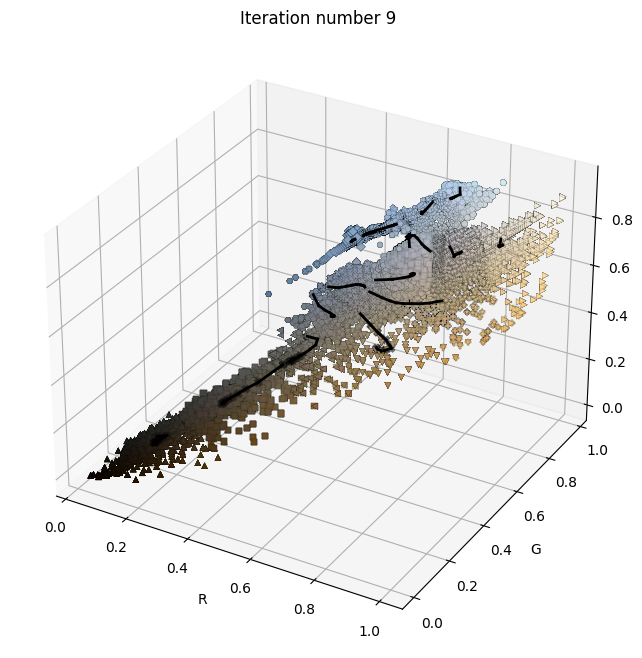

In [23]:
# %matplotlib notebook
K = 16                       
max_iters = 10               

# Init with random centroid 
initial_centroids = kMeans_init_centroids(X_img, K) 

# Run K-Means
centroids, idx = run_kMeans(X_img, initial_centroids, max_iters, plot_progress=True, dim=3)

In [24]:
print("Shape of idx:", idx.shape)
print("Closest centroid for the first five elements:", idx[:5])

Shape of idx: (16384,)
Closest centroid for the first five elements: [15 15 15 15 15]


### Compress the image
After finding the top 𝐾=16 colors to represent the image, we can now assign each pixel position to its closest centroid using the find_closest_centroids function.

In [25]:
# Represent image in terms of indices
X_recovered = centroids[idx, :] 

# Reshape recovered image into proper dimensions
X_recovered = np.reshape(X_recovered, original_img.shape)

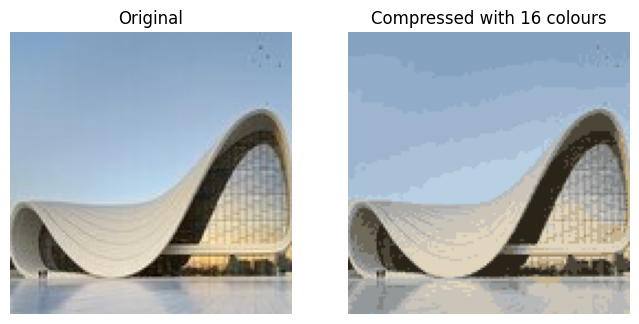

In [26]:
%matplotlib inline
# Display original image
fig, ax = plt.subplots(1,2, figsize=(8,8))
plt.axis('off')

original_img_c = original_img*255
original_img_c = original_img_c.astype(int)
ax[0].imshow(original_img_c)
ax[0].set_title('Original')
ax[0].set_axis_off()


# Display compressed image
X_recovered_c = X_recovered*255
X_recovered_c = X_recovered_c.astype(int)
ax[1].imshow(X_recovered_c)
ax[1].set_title('Compressed with %d colours'%K)
ax[1].set_axis_off()